In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io # 미니맵 처리
from sklearn.preprocessing import MinMaxScaler

In [2]:
# riot api
# RGAPI-7878fe8c-f7f2-4e2e-985f-8103910d5e13

# RATE LIMITS
# 20 requests every 1 seconds(s)
# 100 requests every 2 minutes(s)

- 3렙 탑갱이 승리에 끼치는 영향
- and 바텀 위주 vs 탑 위주
- (미드, 정글), (탑, 정글) 좋은 조합

# 티어별 유저 기본 데이터 가져오기

In [506]:
api_key  = "RGAPI-81eb8571-5c65-4a4e-b5e3-03702a6bf4f2"
kr_api   = "https://kr.api.riotgames.com"
asia_api = "https://asia.api.riotgames.com"

challenger  = f"{kr_api}/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}"
grandmaster = f"{kr_api}/lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}"

# /lol/league/v4/challengerleagues/by-queue/{queue}

# r = requests.get(challenger)  # 챌린져 호출
r = requests.get(grandmaster) # 그마데이터 호출
league_df = pd.DataFrame(r.json())

In [507]:
league_df.head(3)

,tier,leagueId,queue,name,entries
0,GRANDMASTER,a37af09b-ecb8-3664-9453-cf2b0138dd6e,RANKED_SOLO_5x5,Master Yi's Snipers,{'summonerId': 'oNndqMZKeL7fKvZfNuyd7O5ljUe8-Z...
1,GRANDMASTER,a37af09b-ecb8-3664-9453-cf2b0138dd6e,RANKED_SOLO_5x5,Master Yi's Snipers,{'summonerId': 'QHAVUOWJdKJttM30JHd5_tAX_4PHlZ...
2,GRANDMASTER,a37af09b-ecb8-3664-9453-cf2b0138dd6e,RANKED_SOLO_5x5,Master Yi's Snipers,{'summonerId': 'tO9_W459Wb6qLMo-xUipK9wCwxTPpr...


# 소환사 데이터 가져오기

In [508]:
summoner_id   = "JXue7UC14-I2rh7H8TYAUfSxwpo1kw4Ii8dJA4LlVpEajJo"
summoner_name = "코로나공유"

player1  = f"{kr_api}/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}"
response = requests.get(player1)
data     = response.json()
data

{'id': 'JXue7UC14-I2rh7H8TYAUfSxwpo1kw4Ii8dJA4LlVpEajJo',
 'accountId': '5eiUjQC-_2v5pVRd2-4acVLPM0qWl3wYPniCbbpVDcHO-BM',
 'puuid': 'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ',
 'name': '코로나공유',
 'profileIconId': 29,
 'revisionDate': 1632582638000,
 'summonerLevel': 173}

In [509]:
summoner_puuid = data["puuid"]

In [510]:
match_list_api = f"{asia_api}/lol/match/v5/matches/by-puuid/{summoner_puuid}/ids?api_key={api_key}"
response       = requests.get(match_list_api)
match_list     = response.json()

# 기본 0부터 20개
match_list

['KR_5476691788',
 'KR_5476489810',
 'KR_5476449701',
 'KR_5476475155',
 'KR_5474254376',
 'KR_5474322054',
 'KR_5474340497',
 'KR_5474261454',
 'KR_5474194925',
 'KR_5474173379',
 'KR_5473749448',
 'KR_5473639354',
 'KR_5471556997',
 'KR_5469853340',
 'KR_5466288745',
 'KR_5466065552',
 'KR_5464868768',
 'KR_5464567334',
 'KR_5464479467',
 'KR_5464446203']

# match 데이터 가져오기
https://developer.riotgames.com/apis#match-v5/GET_getMatch

In [643]:
match_num = 3
match_data_api   = f"{asia_api}/lol/match/v5/matches/{match_list[match_num]}?api_key={api_key}"
response         = requests.get(match_data_api)
match_basic_data = response.json()

## 시간 변환

In [644]:
# 소환사의 협곡 map_id == 11

# gameDuration 분으로 변환
print(1425655 / 1000 / 60)

# gameCreation 변환
from datetime import datetime
ts = int("1632606364")
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

23.760916666666667
2021-09-25 21:46:04


In [645]:
print(match_basic_data.keys())
print(match_basic_data["info"]["platformId"])
print(match_basic_data["info"]["queueId"])
print(match_basic_data["info"]["tournamentCode"])
# print(match_data["info"]["teams"])

dict_keys(['metadata', 'info'])
KR
420



# 타임라인 match 데이터 가져오기

In [646]:
timeline_match_api = f"{asia_api}/lol/match/v5/matches/{match_list[match_num]}/timeline?api_key={api_key}"

response   = requests.get(timeline_match_api)
time_match = response.json()

In [647]:
time_match.keys()

dict_keys(['metadata', 'info'])

In [648]:
time_match["metadata"]

{'dataVersion': '2',
 'matchId': 'KR_5476475155',
 'participants': ['sh9DiMLwiS0GhV2W8hIGkhb5ingIF2uJ1oHLZYdLL9Rk1OPR0JOHznCeuUeqRNuyqWgaNu1VaBv_hA',
  'N9tFWJKRO03q6Gsx-cGvyFW65eI6ve7AIpi4OUJYCvdfvVfCpENejB60ULpVrN2u8bD9LVTaK75LlA',
  'WIKqhlbDxVig1xRPYuap6bOwEfcEoXVWEWjJfxUJfMwqAzM8evmOQbeUttP0OmchnxPCyB-7iuwmqg',
  'ISw2AJsuc8q9O6xUq6C9NwZjsQYhnaH9cfxQGqsRs5vpIHUZID2Sska3xubwe7Fa3RSB1S7dleuSOw',
  '1k1SZkBrNh3II-Mr9sb8kM3KmAk81UaC2JWmAtQBTzpfIYuJJLWtRoR-NtT_JE0fITKE7sowmYY7Mw',
  'Crtl-wq4RbQ-ZGbiPVUmRQslwZJ2lwwNCFry7Ry3UZWX2egGrn0qFkohP1ibhFSVeL6foz27qIdWfQ',
  'puBj8EjJ3xU43rlT27gTJLuzMr38k2-shzmWcT_0q8k5eYMhB2vnTvuUI3F1AJp6GLtxc5RejIXaaA',
  'CO-DOGnod8-IlvsmYEVjvnrohLcsrGnLR3JeVXUrZFpExH1Ta3onqNxLHvS9Xm18utYLeStoop8RVw',
  '3K2M1CDXgNqfxc4ctntznmXhJjOQXrt_Xkr9y7FM-2rxSpUl3f6fPUhehORhb87Du11NW34XoGtG0w',
  'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ']}

In [649]:
time_match["info"]["participants"]

[{'participantId': 1,
  'puuid': 'sh9DiMLwiS0GhV2W8hIGkhb5ingIF2uJ1oHLZYdLL9Rk1OPR0JOHznCeuUeqRNuyqWgaNu1VaBv_hA'},
 {'participantId': 2,
  'puuid': 'N9tFWJKRO03q6Gsx-cGvyFW65eI6ve7AIpi4OUJYCvdfvVfCpENejB60ULpVrN2u8bD9LVTaK75LlA'},
 {'participantId': 3,
  'puuid': 'WIKqhlbDxVig1xRPYuap6bOwEfcEoXVWEWjJfxUJfMwqAzM8evmOQbeUttP0OmchnxPCyB-7iuwmqg'},
 {'participantId': 4,
  'puuid': 'ISw2AJsuc8q9O6xUq6C9NwZjsQYhnaH9cfxQGqsRs5vpIHUZID2Sska3xubwe7Fa3RSB1S7dleuSOw'},
 {'participantId': 5,
  'puuid': '1k1SZkBrNh3II-Mr9sb8kM3KmAk81UaC2JWmAtQBTzpfIYuJJLWtRoR-NtT_JE0fITKE7sowmYY7Mw'},
 {'participantId': 6,
  'puuid': 'Crtl-wq4RbQ-ZGbiPVUmRQslwZJ2lwwNCFry7Ry3UZWX2egGrn0qFkohP1ibhFSVeL6foz27qIdWfQ'},
 {'participantId': 7,
  'puuid': 'puBj8EjJ3xU43rlT27gTJLuzMr38k2-shzmWcT_0q8k5eYMhB2vnTvuUI3F1AJp6GLtxc5RejIXaaA'},
 {'participantId': 8,
  'puuid': 'CO-DOGnod8-IlvsmYEVjvnrohLcsrGnLR3JeVXUrZFpExH1Ta3onqNxLHvS9Xm18utYLeStoop8RVw'},
 {'participantId': 9,
  'puuid': '3K2M1CDXgNqfxc4ctntznmXhJjOQXrt_Xkr9y7

In [650]:
match_data = time_match["info"]["frames"]

In [651]:
"""
events: 게임 내에서 발생한 사건 데이터
participantFrames: 각 플레이어 인게임 정보
timestamp: 기록된 시간(1분마다 기록이 된다.)

match_data는 1분 단위로 기록됩니다.
"""
print(len(match_data))
match_data[0].keys()

32


dict_keys(['events', 'participantFrames', 'timestamp'])

## 한 경기에서 나오는 모든 이벤트 종류

In [652]:
event_types = []
for match in match_data:
    for event in match["events"]:
        event_types.append(event["type"])
list(set(event_types))

['PAUSE_END',
 'CHAMPION_KILL',
 'ITEM_SOLD',
 'ELITE_MONSTER_KILL',
 'ITEM_DESTROYED',
 'LEVEL_UP',
 'SKILL_LEVEL_UP',
 'WARD_KILL',
 'WARD_PLACED',
 'CHAMPION_SPECIAL_KILL',
 'GAME_END',
 'ITEM_UNDO',
 'TURRET_PLATE_DESTROYED',
 'BUILDING_KILL',
 'ITEM_PURCHASED']

# 플레이어 포지션 구분

라인 구분하는 기준에 관련한 docs 입니다. <br>
https://riot-api-libraries.readthedocs.io/en/latest/roleid.html
- Role과 Lane 데이터를 사용하여 Postion을 정하면 87.5%의 정확도를 가집니다.

> The easiest (and most inaccurate) way to correct roles is to just use the Role and Lane data and convert to Position based on the below mapping. This yields about 87.5% accuracy. <br>
    (MID_LANE, SOLO): MIDDLE, <br>
    (TOP_LANE, SOLO): TOP, <br>
    (JUNGLE, NONE): JUNGLE, <br>
    (BOT_LANE, DUO_CARRY): BOTTOM, <br>
    (BOT_LANE, DUO_SUPPORT): UTILITY <br>

In [653]:
print(match_basic_data.keys())
print(match_basic_data["info"].keys())

dict_keys(['metadata', 'info'])
dict_keys(['gameCreation', 'gameDuration', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])


In [702]:
n = 8
match_basic_data["info"]["participants"][n]["summonerId"]
print(match_basic_data["info"]["participants"][n]["championName"])
match_basic_data["info"]["participants"][n]["championId"]

match_basic_data["info"]["participants"][n]["puuid"]
# print(match_basic_data["info"]["participants"][n]["participantId"])
# print(match_basic_data["info"]["participants"][n]["teamId"])

print(match_basic_data["info"]["participants"][n]["role"])
print(match_basic_data["info"]["participants"][n]["lane"])
print(match_basic_data["info"]["participants"][n]["individualPosition"])
print(match_basic_data["info"]["participants"][n]["teamPosition"])

MissFortune
CARRY
BOTTOM
BOTTOM
BOTTOM


In [693]:
match_basic_data["info"]["participants"][n]

{'assists': 8,
 'baronKills': 0,
 'bountyLevel': 0,
 'champExperience': 12996,
 'champLevel': 14,
 'championId': 21,
 'championName': 'MissFortune',
 'championTransform': 0,
 'consumablesPurchased': 2,
 'damageDealtToBuildings': 2701,
 'damageDealtToObjectives': 13042,
 'damageDealtToTurrets': 2701,
 'damageSelfMitigated': 9293,
 'deaths': 5,
 'detectorWardsPlaced': 1,
 'doubleKills': 1,
 'dragonKills': 1,
 'firstBloodAssist': False,
 'firstBloodKill': False,
 'firstTowerAssist': False,
 'firstTowerKill': False,
 'gameEndedInEarlySurrender': False,
 'gameEndedInSurrender': True,
 'goldEarned': 12423,
 'goldSpent': 11925,
 'individualPosition': 'BOTTOM',
 'inhibitorKills': 0,
 'inhibitorTakedowns': 0,
 'inhibitorsLost': 1,
 'item0': 3142,
 'item1': 3035,
 'item2': 1055,
 'item3': 6676,
 'item4': 6692,
 'item5': 3047,
 'item6': 3363,
 'itemsPurchased': 20,
 'killingSprees': 1,
 'kills': 5,
 'lane': 'BOTTOM',
 'largestCriticalStrike': 717,
 'largestKillingSpree': 4,
 'largestMultiKill': 2

In [694]:
# match_data[-1]["participantFrames"]["4"]

In [695]:
print(time_match["info"].keys())
time_match["info"]["participants"]

# 스마와 정글몹 킬 수로 정글러 파악 가능
# match_data[-1]["participantFrames"]["4"]["jungleMinionsKilled"]

# 미니언 킬 수, 레벨이 가장 낮은 플레이어가 서폿

dict_keys(['frameInterval', 'frames', 'gameId', 'participants'])


[{'participantId': 1,
  'puuid': 'sh9DiMLwiS0GhV2W8hIGkhb5ingIF2uJ1oHLZYdLL9Rk1OPR0JOHznCeuUeqRNuyqWgaNu1VaBv_hA'},
 {'participantId': 2,
  'puuid': 'N9tFWJKRO03q6Gsx-cGvyFW65eI6ve7AIpi4OUJYCvdfvVfCpENejB60ULpVrN2u8bD9LVTaK75LlA'},
 {'participantId': 3,
  'puuid': 'WIKqhlbDxVig1xRPYuap6bOwEfcEoXVWEWjJfxUJfMwqAzM8evmOQbeUttP0OmchnxPCyB-7iuwmqg'},
 {'participantId': 4,
  'puuid': 'ISw2AJsuc8q9O6xUq6C9NwZjsQYhnaH9cfxQGqsRs5vpIHUZID2Sska3xubwe7Fa3RSB1S7dleuSOw'},
 {'participantId': 5,
  'puuid': '1k1SZkBrNh3II-Mr9sb8kM3KmAk81UaC2JWmAtQBTzpfIYuJJLWtRoR-NtT_JE0fITKE7sowmYY7Mw'},
 {'participantId': 6,
  'puuid': 'Crtl-wq4RbQ-ZGbiPVUmRQslwZJ2lwwNCFry7Ry3UZWX2egGrn0qFkohP1ibhFSVeL6foz27qIdWfQ'},
 {'participantId': 7,
  'puuid': 'puBj8EjJ3xU43rlT27gTJLuzMr38k2-shzmWcT_0q8k5eYMhB2vnTvuUI3F1AJp6GLtxc5RejIXaaA'},
 {'participantId': 8,
  'puuid': 'CO-DOGnod8-IlvsmYEVjvnrohLcsrGnLR3JeVXUrZFpExH1Ta3onqNxLHvS9Xm18utYLeStoop8RVw'},
 {'participantId': 9,
  'puuid': '3K2M1CDXgNqfxc4ctntznmXhJjOQXrt_Xkr9y7

# 플레이어 동선 시각화 (726*600)

In [696]:
axes   = []
minute = 5

for order_num in match_data[minute]["participantFrames"]:
    cur_position = match_data[minute]["participantFrames"][order_num]["position"]
    x, y = cur_position["x"], cur_position["y"]
    axes.append([x, y])

In [697]:
x_range = np.array([0, 15000]).reshape((-1, 1))
y_range = np.array([0, 15000]).reshape((-1, 1)) 

# x 따로, y 따로
x_axes = [[ax[0]] for ax in axes]
y_axes = [[ax[1]] for ax in axes]

# 0부터 50, 680 부터 726, 총 96
player_x_scaler = MinMaxScaler(feature_range=(40, 680)).fit(x_range)
# player_x_scaler = MinMaxScaler(feature_range=(0, 726)).fit(x_range)

# 0부터 20, 580부터 600, 총 40
player_y_scaler = MinMaxScaler(feature_range=(10, 580)).fit(y_range)
# player_y_scaler = MinMaxScaler(feature_range=(0, 600)).fit(y_range)

player_x_position = player_x_scaler.transform(x_axes)
player_y_position = player_y_scaler.transform(y_axes)

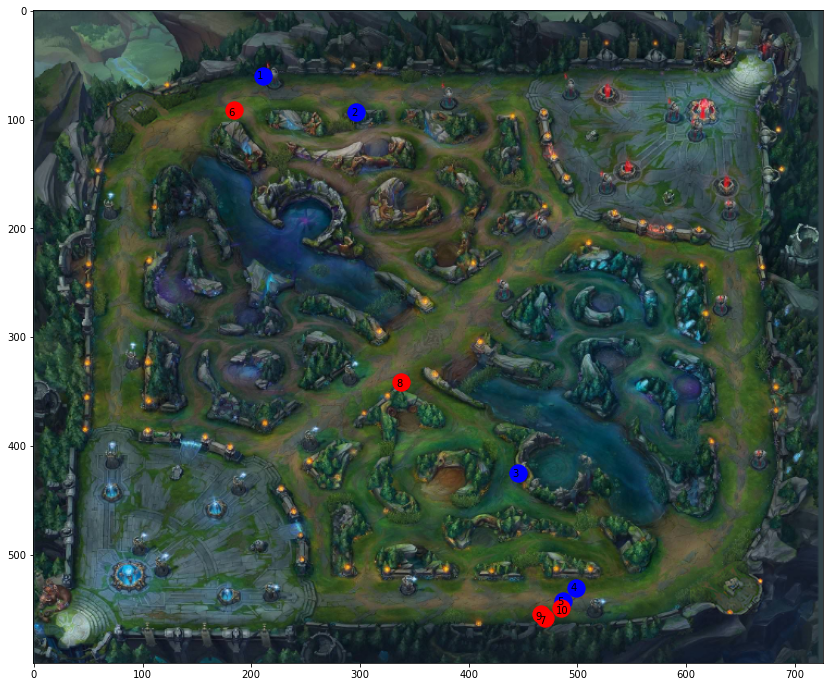

In [698]:
# 726 * 600 사이즈
map_url = "https://preview.redd.it/anfqyl1ef2041.png?width=726&format=png&auto=webp&s=a93e43da6d4e0f702cd54fafa5dacc3111bce8fb"
image   = io.imread(map_url)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

i = 1
for position_x, position_y in zip(player_x_position, player_y_position):
    # red 팀
    if i < 6:
        # 각각의 값은 이미지에 맞게 좌표를 추가적 스케일링을 진행한 것입니다.
        ax.scatter(position_x + 15, 600 - position_y - 15, c="blue", s=300)
        ax.annotate(text=f"{i}",  xy=(position_x + 10, 600 - position_y - 12))
    
    # blue 팀
    else:
        # 각각의 값은 이미지에 맞게 좌표를 추가적 스케일링을 진행한 것입니다.
        ax.scatter(position_x - 30, 600 - position_y + 30, c="red", s=300)
        ax.annotate(text=f"{i}",  xy=(position_x - 35, 600 - position_y + 35))
    i += 1
    
ax.axis('on')
ax.imshow(image)
plt.show()

In [564]:
# # 0부터 50, 680부터 726, 총 96
# # 0부터 20, 580부터 600, 총 40

# img_url = "https://preview.redd.it/anfqyl1ef2041.png?width=726&format=png&auto=webp&s=a93e43da6d4e0f702cd54fafa5dacc3111bce8fb"
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# ax.scatter([50], [100], c='white', s=50)
# ax.axis('on')
# ax.imshow(io.imread(img_url))
# plt.show()

# ax.set_xlim(0, 1200)
# ax.set_ylim(1200, 0)
# plt.tight_layout()
# plt.show()